# Детекция лиц с использованием архитектуры VGG16

# 1. Подготовка датасета
В качестве датасета выбран датасет **VGG16** с большим количеством изображений и соотвествующих им координат прямоугольника лиц `(x, y, w, h)`.

## Подготовка аннотаций из датасета
Сначала извлечем аннотации из датасета в формате `(путь_к_изображению, список_координат_лиц_изображения)`. Поскольку датасет большой, а обучать на сильно больших данных не можем ввиду слабого ПК без `GPU`, аннотации для тренировочних данных и для валидации будем брать из папки изображений с тренировочными данными.

In [1]:
from sklearn.model_selection import train_test_split
import cv2
import os

In [2]:
WIDER_FACE_PATH = "C:/Users/PAVILION/Desktop/Coding/Datasets/wider_face/"
WITHOUT_FACE_PATH = "C:/Users/PAVILION/Desktop/Coding/Datasets/random_img_without_face/"
DATASETS_PATH = "C:/Users/PAVILION/Desktop/Coding/Datasets/"

In [3]:
def demonstrate(annots, n):
    for i in range(n):
        # Загружаем изображение
        image = cv2.imread(DATASETS_PATH + annots[i][0])  # путь к файлу
        
        # Получаем размеры изображения
        height, width = image.shape[:2]
        
        for rect in annots[i][1]:
            # Рисуем прямоугольник (рамку)
            # cv2.rectangle(изображение, (x1, y1), (x2, y2), (B, G, R), толщина)
            x, y, w, h = rect
            cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 3)
        
        # Выводим изображение
        cv2.imshow("Image with Frame", image)
        cv2.waitKey(0)  # Ждём нажатия любой клавиши
        cv2.destroyAllWindows()  # Закрываем окно

In [4]:
all_annotations = []
with open(WIDER_FACE_PATH + "wider_face_split/wider_face_train_bbx_gt.txt", 'r') as f:
    lines = f.readlines()
i = 0
while i < len(lines):
    img_name = "wider_face/WIDER_train/images/" + lines[i].strip()
    i += 1
    num_boxes = int(lines[i].strip())
    i += 1
    bboxes = []
    for _ in range(num_boxes):
        if i >= len(lines):
            break
        box_data = list(map(int, lines[i].strip().split()[:4]))
        bboxes.append(box_data)
        i += 1
    # Фильтрация: отбираем изображения с одним лицом площадью > 2000 (w*h) и не относящееся к сложным темам 
    if len(bboxes) == 1 and bboxes != [[]] and\
         bboxes[0][2]*bboxes[0][3] > 1500 and\
         ('3--Riot' or '24--Soldier_Firing' or '25--Soldier_Patrol' or '26--Soldier_Drilling' or '27--Spa' or\
          '34--Baseball' or '36--Football' or '43--Row_Boat' or '52--Photographers' or '53--Raid' or '54--Rescue' or\
          '58--Hockey') not in img_name:
        all_annotations.append((img_name, bboxes))

In [5]:
all_annotations[0]

('wider_face/WIDER_train/images/0--Parade/0_Parade_marchingband_1_849.jpg',
 [[449, 330, 122, 149]])

In [6]:
len(all_annotations)

4382

In [71]:
demonstrate(all_annotations, 10)

Избавимся от нечетких лиц, обработав их с помощью OpenCV. Если OpenCV не найдет лицо, удалим аннотацию

In [8]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

for i, (img_path, face_coords) in enumerate(all_annotations):
    img = cv2.imread(DATASETS_PATH+img_path)

    if img is None:
        print(f"Не удалось загрузить изображение: {img_path}")
        continue

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

    if len(faces) == 0:
        all_annotations.pop(i)

In [9]:
len([annotation for annotation in all_annotations if annotation[1] == [[0, 0, 0, 0]]])

0

Добавление аннотаций изображений без лиц

In [10]:
for filename in os.listdir(WITHOUT_FACE_PATH):
    img_name = os.path.join("random_img_without_face/", filename)
    all_annotations.append((img_name, [[0, 0, 0, 0]]))

In [11]:
len(all_annotations)

6510

In [12]:
print('Аннотаций изображений с лицами:', len([annotation for annotation in all_annotations if annotation[1] != [[0, 0, 0, 0]]]))
print('Аннотаций изображений без лиц:', len([annotation for annotation in all_annotations if annotation[1] == [[0, 0, 0, 0]]]))

Аннотаций изображений с лицами: 3546
Аннотаций изображений без лиц: 2964


In [13]:
demonstrate(all_annotations, 10)

Сохраним наши аннотации в `json`

In [14]:
import json
json_ready = [[path, coords] for (path, coords) in all_annotations]
with open("annotations_without_unclear_faces.json", "w", encoding="utf-8") as f:
    json.dump(json_ready, f, ensure_ascii=False, indent=2)

Для импортирования аннотаций

In [3]:
import json
with open("annotations_without_unclear_faces.json", "r", encoding="utf-8") as f:
    all_annotations = json.load(f)

## Подготовка данных для обучения
Сначала импортируем библиотеки для работы с изображениями.

In [4]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img

Чтобы подготовить данные для обучения нейросети, извлечем по отдельности изображения для тренировки и валидации, координаты лиц для изображений и классовую метку о наличие лица на изображении (`train_images`, `train_bboxes`, `train_labels` и  `val_images`, `val_bboxes`, `val_labels`).

1. Загрузим изображение
2. Изменим размер изображения до стандартного (224x224)
3. Нормализуем значения пикселей
4. Нормализуем координаты ограничивающих прямоугольников (из пикселей в относительные значения от 0 до 1).

In [17]:
# Разделение на train/val
train_annots, val_annots = train_test_split(all_annotations, test_size=0.3, random_state=42)

In [5]:
# Размер изображения для VGG16
IMG_HEIGHT, IMG_WIDTH = 224, 224

In [6]:
from PIL import Image
import random
import numpy as np

In [7]:
def preprocess_data(annotation_list, target_size=(IMG_HEIGHT, IMG_WIDTH)):
    images = []
    bboxes = []
    labels = []

    for img_path, annots in annotation_list:
        full_path_to_img = DATASETS_PATH + img_path
        
        try:
            with Image.open(full_path_to_img) as original_pil_img:
                original_width, original_height = original_pil_img.size

            img = load_img(full_path_to_img, target_size=target_size)
            # img = img_to_array(img) / 255.0
            images.append(img)

            bbox = annots[0]
            x, y, w, h = bbox

            x_min_abs = x
            y_min_abs = y
            x_max_abs = x + w
            y_max_abs = y + h
            
            norm_x_min = x_min_abs / original_width
            norm_y_min = y_min_abs / original_height
            norm_x_max = x_max_abs / original_width
            norm_y_max = y_max_abs / original_height
            
            bboxes.append([norm_x_min, norm_y_min, norm_x_max, norm_y_max])
            
            if bbox != [0, 0, 0, 0]:
                labels.append(1)
            else:
                labels.append(0)

        except FileNotFoundError:
            print(f"Ошибка: Файл не найден по пути {full_path_to_img}. Пропускаем.")
            continue
        except Exception as e:
            print(f"Ошибка при открытии изображения {full_path_to_img}: {e}. Пропускаем.")
            continue

    return np.array(images), np.array(bboxes), np.array(labels)

In [21]:
print("Обработка тренировочных данных...")
train_images, train_bboxes, train_labels = preprocess_data(train_annots)

print(f"Размер тренировочных изображений: {train_images.shape}")
print(f"Размер тренировочных bbox: {train_bboxes.shape}")
print(f"Размер тренировочных меток: {train_labels.shape}")

Обработка тренировочных данных...
Размер тренировочных изображений: (4557, 224, 224, 3)
Размер тренировочных bbox: (4557, 4)
Размер тренировочных меток: (4557,)


In [22]:
print("Обработка валидационных данных...")
val_images, val_bboxes, val_labels = preprocess_data(val_annots)

print(f"Размер валидационных изображений: {val_images.shape}")

Обработка валидационных данных...
Размер валидационных изображений: (1953, 224, 224, 3)


In [23]:
print('Количество пустых изображений в train: ', len(train_labels[train_labels == 0]))
print('Количество пустых изображений в val: ', len(val_labels[val_labels == 0]))

Количество пустых изображений в train:  2085
Количество пустых изображений в val:  879


In [24]:
def show_images_with_bboxes_opencv(images, bboxes, labels=None, num=5):
    for i in range(num):
        img = images[i].copy()  # копируем, чтобы не изменять исходное
        bbox = bboxes[i]
        
        h, w = img.shape[:2]
        x1, y1, x2, y2 = bbox
        # преобразуем нормализованные координаты в пиксели
        pt1 = (int(x1 * w), int(y1 * h))
        pt2 = (int(x2 * w), int(y2 * h))
        
        # Преобразуем изображение из float32 (0..1) в uint8 (0..255)
        # img_show = (img * 255).astype(np.uint8)
        img_show = (img).astype(np.uint8)
        img_show = cv2.cvtColor(img_show, cv2.COLOR_RGB2BGR)  # RGB -> BGR для OpenCV
        
        # Рисуем прямоугольник
        cv2.rectangle(img_show, pt1, pt2, color=(0, 0, 255), thickness=2)
        
        # Если есть метки, выводим их на изображение
        if labels is not None:
            label = str(labels[i])
            cv2.putText(img_show, label, (pt1[0], pt1[1]-10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2)
        
        # Показываем изображение в окне
        cv2.imshow(f'Image {i+1}', img_show)
        cv2.waitKey(0)  # ждем нажатия любой клавиши
        cv2.destroyAllWindows()

In [72]:
show_images_with_bboxes_opencv(train_images, train_bboxes, train_labels, num=3)

In [26]:
train_bboxes[0]

array([0.42578125, 0.14071511, 0.65429688, 0.47289504])

## Аугментация

In [36]:
import albumentations as alb
augmentor = alb.Compose([alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(brightness_limit=0.4, contrast_limit=0.4, p=0.5),
                         alb.RandomGamma(gamma_limit=(50, 150), p=0.5), 
                         alb.RGBShift(r_shift_limit=50, g_shift_limit=50, b_shift_limit=50, p=0.5), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', label_fields=['class_labels']))

In [38]:
augmented_images_train = []
augmented_boxes_train = []
augmented_labels_train = []
# k = 0
for img, box, label in zip(train_images, train_bboxes, train_labels):
    if label == 1:
        bboxes = [box]
        class_labels = [1]
    else:
        bboxes = []
        class_labels = []

    augmented = augmentor(image=img, bboxes=bboxes, class_labels=class_labels)

    augmented_images_train.append(augmented['image'])

    if augmented['bboxes']:
        augmented_boxes_train.append(augmented['bboxes'][0])
        augmented_labels_train.append(1)
    else:
        augmented_boxes_train.append([0, 0, 0, 0])  # можно оставить для согласованности
        augmented_labels_train.append(0)
    # k += 1
    # if k == 10:
    #     show_images_with_bboxes_opencv(augmented_images_train, augmented_boxes_train, augmented_labels_train, num=10)
    #     break

In [39]:
augmented_images_val = []
augmented_boxes_val = []
augmented_labels_val = []

for img, box, label in zip(val_images, val_bboxes, val_labels):
    if label == 1:
        bboxes = [box]
        class_labels = [1]
    else:
        bboxes = []
        class_labels = []

    augmented = augmentor(image=img, bboxes=bboxes, class_labels=class_labels)

    augmented_images_val.append(augmented['image'])

    if augmented['bboxes']:
        augmented_boxes_val.append(augmented['bboxes'][0])
        augmented_labels_val.append(1)
    else:
        augmented_boxes_val.append([0, 0, 0, 0])  # можно оставить для согласованности
        augmented_labels_val.append(0)

In [73]:
show_images_with_bboxes_opencv(augmented_images_train, augmented_boxes_train, augmented_labels_train, num=3)

In [74]:
show_images_with_bboxes_opencv(augmented_images_val, augmented_boxes_val, augmented_labels_val, num=3)

In [52]:
augmented_images_train[0]

array([[[220, 229, 240],
        [220, 229, 240],
        [220, 229, 240],
        ...,
        [252, 255, 255],
        [252, 255, 255],
        [252, 255, 255]],

       [[220, 229, 240],
        [220, 229, 240],
        [219, 228, 240],
        ...,
        [251, 255, 255],
        [254, 255, 255],
        [254, 255, 255]],

       [[220, 229, 240],
        [220, 229, 240],
        [219, 228, 240],
        ...,
        [251, 255, 255],
        [252, 255, 255],
        [254, 255, 255]],

       ...,

       [[226, 238, 255],
        [222, 234, 255],
        [221, 233, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[241, 254, 255],
        [236, 249, 255],
        [236, 249, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[243, 255, 255],
        [240, 255, 255],
        [237, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

Нормализуем изображения

In [53]:
augmented_images_train = [img.astype(np.float32) / 255.0 for img in augmented_images_train]
augmented_boxes_train[0]

[0.345703125, 0.1407151073217392, 0.57421875, 0.4728950262069702]

In [54]:
augmented_images_train[0]

array([[[0.8627451 , 0.8980392 , 0.9411765 ],
        [0.8627451 , 0.8980392 , 0.9411765 ],
        [0.8627451 , 0.8980392 , 0.9411765 ],
        ...,
        [0.9882353 , 1.        , 1.        ],
        [0.9882353 , 1.        , 1.        ],
        [0.9882353 , 1.        , 1.        ]],

       [[0.8627451 , 0.8980392 , 0.9411765 ],
        [0.8627451 , 0.8980392 , 0.9411765 ],
        [0.85882354, 0.89411765, 0.9411765 ],
        ...,
        [0.9843137 , 1.        , 1.        ],
        [0.99607843, 1.        , 1.        ],
        [0.99607843, 1.        , 1.        ]],

       [[0.8627451 , 0.8980392 , 0.9411765 ],
        [0.8627451 , 0.8980392 , 0.9411765 ],
        [0.85882354, 0.89411765, 0.9411765 ],
        ...,
        [0.9843137 , 1.        , 1.        ],
        [0.9882353 , 1.        , 1.        ],
        [0.99607843, 1.        , 1.        ]],

       ...,

       [[0.8862745 , 0.93333334, 1.        ],
        [0.87058824, 0.91764706, 1.        ],
        [0.8666667 , 0

In [55]:
augmented_images_val = [img.astype(np.float32) / 255.0 for img in augmented_images_val]
augmented_images_val[0]

array([[[0.23137255, 0.11764706, 0.        ],
        [0.23137255, 0.11764706, 0.        ],
        [0.22745098, 0.11372549, 0.        ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.23529412, 0.12156863, 0.        ],
        [0.23529412, 0.12156863, 0.        ],
        [0.23137255, 0.11764706, 0.        ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.23921569, 0.1254902 , 0.        ],
        [0.23921569, 0.1254902 , 0.        ],
        [0.23529412, 0.12156863, 0.        ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       ...,

       [[0.84705883, 0.84705883, 0.85490197],
        [0.8392157 , 0.8392157 , 0.84705883],
        [0.85490197, 0

Проверим shape после аугментации

In [58]:
augmented_images_train = np.array(augmented_images_train)
augmented_boxes_train = np.array(augmented_boxes_train)
augmented_labels_train = np.array(augmented_labels_train)

augmented_images_val = np.array(augmented_images_val)
augmented_boxes_val = np.array(augmented_boxes_val)
augmented_labels_val = np.array(augmented_labels_val)

# 2. Проектирование и обучение модели
Для построение модели будем использовать архитектуру VGG16, но VGG16 - это классификационная модель. Ее можно использовать как основу для создания модели детекции, используя ее как экстрактор признаков.

В сверточной голове реализуем предсказание 4-х координат одного лица и вероятность наличия лица.

## Создание модели

In [42]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.applications import VGG16

In [43]:
def create_face_detection_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)):
    # Загрузка предобученной VGG16 без верхних слоев
    vgg = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=input_shape))

    # Замораживаем слои VGG16, чтобы не переобучать их на нашем маленьком датасете
    for layer in vgg.layers:
        layer.trainable = False

    # Добавляем свои слои поверх VGG16
    flatten = vgg.output
    flatten = Flatten()(flatten)

    # Output head для предсказания ограничивающих прямоугольников
    bboxHead = Dense(128, activation="relu")(flatten)
    bboxHead = Dense(64, activation="relu")(bboxHead)
    bboxHead = Dense(32, activation="relu")(bboxHead)
    bboxOutput = Dense(4, activation="sigmoid", name="bbox_output")(bboxHead) # sigmoid для нормализованных [0,1]

    # Output head для классификации наличия лица
    classHead = Dense(128, activation="relu")(flatten)
    classHead = Dense(64, activation="relu")(classHead)
    classHead = Dense(1, activation="sigmoid", name="class_output")(classHead) # sigmoid для бинарной классификации (есть/нет лицо)

    # Создаем модель с двумя выходами
    model = Model(inputs=vgg.input, outputs=[bboxOutput, classHead])

    return model

In [45]:
from tensorflow.keras.optimizers import Adam

In [46]:
model = create_face_detection_model()
model.summary()

# Компиляция модели
# Для bbox используем MSE, для классификации - BinaryCrossentropy
losses = {
    "bbox_output": "mean_squared_error",
    "class_output": "binary_crossentropy"
}
loss_weights = {
    "bbox_output": 1.0,
    "class_output": 0.5
}
optimizer = Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer, loss=losses, loss_weights=loss_weights, metrics={'class_output': 'accuracy'})

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv1 (Conv2D)         │ (None, 224, 224, 64)      │           1,792 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv2 (Conv2D)         │ (None, 224, 224, 64)      │          36,928 │ block1_conv1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_pool (MaxPooling2D)    │ (None, 112, 112, 64)      │               0 │ block1_conv2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_conv1 (Conv2D)         │ (None, 112, 112, 128)     │          73,856 │ block1_pool[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_conv2 (Conv2D)         │ (None, 112, 112, 128)     │         147,584 │ block2_conv1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_pool (MaxPooling2D)    │ (None, 56, 56, 128)       │               0 │ block2_conv2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block3_conv1 (Conv2D)         │ (None, 56, 56, 256)       │         295,168 │ block2_pool[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block3_conv2 (Conv2D)         │ (None, 56, 56, 256)       │         590,080 │ block3_conv1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block3_conv3 (Conv2D)         │ (None, 56, 56, 256)       │         590,080 │ block3_conv2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block3_pool (MaxPooling2D)    │ (None, 28, 28, 256)       │               0 │ block3_conv3[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block4_conv1 (Conv2D)         │ (None, 28, 28, 512)       │       1,180,160 │ block3_pool[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block4_conv2 (Conv2D)         │ (None, 28, 28, 512)       │       2,359,808 │ block4_conv1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block4_conv3 (Conv2D)         │ (None, 28, 28, 512)       │       2,359,808 │ block4_conv2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block4_pool (MaxPooling2D)    │ (None, 14, 14, 512)       │               0 │ block4_conv3[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block5_conv1 (Conv2D)         │ (None, 14, 14, 512)       │       2,359,808 │ block4_pool[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block5_conv2 (Conv2D)         │ (None, 14, 14, 512)       │       2,359,808 │ block5_conv1[0][0]         │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 21,156,261 (80.70 MB)

 Trainable params: 6,441,573 (24.57 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

## Обучение

In [59]:
EPOCHS = 20 
BATCH_SIZE = 16 

print("Начало обучения модели...")
history = model.fit(
    augmented_images_train,
    {"bbox_output": augmented_boxes_train, "class_output": augmented_labels_train},
    validation_data=(augmented_images_val, {"bbox_output": augmented_boxes_val, "class_output": augmented_labels_val}),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)
print("Обучение завершено.")

base_save_dir = r"C:\Users\PAVILION\Desktop\Coding\TrainedModels"
model_save_path_keras = os.path.join(base_save_dir, "face_detection_first_model_15_06_25.keras")
try:
    model.save(model_save_path_keras)
    print(f"Модель успешно сохранена в: {model_save_path_keras}")
except Exception as e:
    print(f"Ошибка при сохранении модели: {e}")

Начало обучения модели...
Epoch 1/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 1000s 3s/step - bbox_output_loss: 0.0551 - class_output_accuracy: 0.8260 - class_output_loss: 0.3413 - loss: 0.2257 - val_bbox_output_loss: 0.0257 - val_class_output_accuracy: 0.9498 - val_class_output_loss: 0.1354 - val_loss: 0.0935
Epoch 2/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 995s 3s/step - bbox_output_loss: 0.0178 - class_output_accuracy: 0.9690 - class_output_loss: 0.0926 - loss: 0.0641 - val_bbox_output_loss: 0.0186 - val_class_output_accuracy: 0.9601 - val_class_output_loss: 0.0980 - val_loss: 0.0672
Epoch 3/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 1014s 4s/step - bbox_output_loss: 0.0110 - class_output_accuracy: 0.9903 - class_output_loss: 0.0444 - loss: 0.0332 - val_bbox_output_loss: 0.0179 - val_class_output_accuracy: 0.9662 - val_class_output_loss: 0.0950 - val_loss: 0.0657
Epoch 4/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 1020s 4s/step - bbox_output_loss: 0.0075 - class_output_accuracy: 0.9921 - class_output_loss: 0.0294 - loss: 0.02

KeyboardInterrupt: 

In [60]:
base_save_dir = r"C:\Users\PAVILION\Desktop\Coding\TrainedModels"
model_save_path_keras = os.path.join(base_save_dir, "face_detection_first_model_15_06_25.keras")
try:
    model.save(model_save_path_keras)
    print(f"Модель успешно сохранена в: {model_save_path_keras}")
except Exception as e:
    print(f"Ошибка при сохранении модели: {e}")

Модель успешно сохранена в: C:\Users\PAVILION\Desktop\Coding\TrainedModels\face_detection_first_model_15_06_25.keras


# 3. Оценка качества модели

In [62]:
import matplotlib.pyplot as plt


hist = history
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

NameError: name 'history' is not defined

In [63]:

def plot_training_history(history):
    # Получаем данные из объекта history
    # Потери для bounding box и классификации
    bbox_loss = history.history['bbox_mae']
    val_bbox_loss = history.history['val_bbox_mae']
    class_loss = history.history['class_loss']
    val_class_loss = history.history['val_class_loss']

    total_loss = history.history['loss']

    epochs = range(1, len(total_loss) + 1)

    # График потерь для Bounding Box (MAE)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, bbox_loss, 'b', label='Потеря BBox на обучении')
    plt.plot(epochs, val_bbox_loss, 'r', label='Потеря BBox на валидации')
    plt.title('Потеря Bounding Box (MAE)')
    plt.xlabel('Эпохи')
    plt.ylabel('Потеря MAE')
    plt.legend()
    plt.grid(True)
    
    # График потерь для классификации (Binary Crossentropy)
    plt.subplot(1, 2, 2)
    plt.plot(epochs, class_loss, 'b', label='Потеря класса на обучении')
    plt.plot(epochs, val_class_loss, 'r', label='Потеря класса на валидации')
    plt.title('Потеря классификации (Binary Crossentropy)')
    plt.xlabel('Эпохи')
    plt.ylabel('Потеря BCE')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Вызов функции для построения графиков
plot_training_history(hist)

NameError: name 'hist' is not defined

## Проверка работы модели в реальном времени

In [66]:
# model = model_2
import cv2
import numpy as np

cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    orig_h, orig_w = frame.shape[:2]

    # Предобработка изображения
    resized = cv2.resize(frame, (224, 224))
    input_tensor = resized.astype('float32') / 255.0
    input_tensor = np.expand_dims(input_tensor, axis=0)  # (1, 224, 224, 3)

    # Предсказание: модель вернёт (class_pred, bbox_pred)
    bbox_pred, class_pred = model.predict(input_tensor)

    # Обработка результатов (batch = 1)
    class_score = class_pred[0][0]  # scalar (вероятность наличия объекта)
    bbox = bbox_pred[0]             # [x_min, y_min, x_max, y_max] в нормализованных координатах

    # Проверка уверенности
    print(class_score, bbox)
    if class_score > 0.2:
        x1 = int(bbox[0] * orig_w)
        y1 = int(bbox[1] * orig_h)
        x2 = int(bbox[2] * orig_w)
        y2 = int(bbox[3] * orig_h)

        # Рисуем рамку
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(frame, f"{class_score:.2f}", (x1, y1 - 10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    # Отображение окна
    cv2.imshow('Face Detection', frame)

    # Выход по клавише 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Освобождение ресурсов
cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step
0.99999994 [0.4248142 0.2031816 0.6576004 0.7234298]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
0.99999994 [0.42835748 0.24369867 0.6597177  0.6974396 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
0.99999994 [0.43156323 0.24853107 0.6638939  0.70087063]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
0.99999994 [0.4330105 0.247463  0.6627629 0.698701 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
0.99999994 [0.43107364 0.24507241 0.6621516  0.6913688 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step
0.99999994 [0.42971048 0.24694462 0.66044736 0.68859196]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
0.99999994 [0.43462718 0.24827467 0.6611869  0.6951831 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
0.99999994 [0.43463424 0.24620587 0.66412926 0.6936084 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
0.99999994 [0.43055114 0.24557704 0.6603937  0.6917951 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
0.99999994 [0.43623093 0.26329932 0.65743315 0.6958289 ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
0.9999999

In [26]:
cap = cv2.VideoCapture(0)

# Освобождение ресурсов
cap.release()
cv2.destroyAllWindows()

error: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:1295: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvDestroyAllWindows'


In [33]:
def show_predictions_on_images(model, images, true_bboxes=None, labels=None, num=5, image_size=(224, 224)):
    """
    Показывает изображения с предсказанными bbox от модели и, опционально, реальными bbox и метками.
    """
    for i in range(num):
        img = images[i]
        input_img = np.expand_dims(img, axis=0)

        # Предсказание модели (ожидаем [bbox, class])
        pred = model.predict(input_img, verbose=0)
        if isinstance(pred, list) and len(pred) == 2:
            pred_bbox = pred[0][0]  # Извлекаем bbox предсказание (1D массив длины 4)
        else:
            pred_bbox = pred[0]  # Если только bbox — используем как есть

        pred_bbox = np.squeeze(pred_bbox)  # Убираем лишние размерности

        # Подготовка изображения для отображения
        img_disp = (img * 255).astype(np.uint8)
        img_disp = cv2.cvtColor(img_disp, cv2.COLOR_RGB2BGR)

        h, w = image_size

        # Преобразуем нормализованные координаты в пиксели
        x1_pred = int(pred_bbox[0] * w)
        y1_pred = int(pred_bbox[1] * h)
        x2_pred = int(pred_bbox[2] * w)
        y2_pred = int(pred_bbox[3] * h)

        # Рисуем предсказанный bbox (красный)
        cv2.rectangle(img_disp, (x1_pred, y1_pred), (x2_pred, y2_pred), (0, 0, 255), 2)

        # Реальный bbox (зелёный)
        if true_bboxes is not None:
            x1_true = int(true_bboxes[i][0] * w)
            y1_true = int(true_bboxes[i][1] * h)
            x2_true = int(true_bboxes[i][2] * w)
            y2_true = int(true_bboxes[i][3] * h)
            cv2.rectangle(img_disp, (x1_true, y1_true), (x2_true, y2_true), (0, 255, 0), 2)

        # Метка класса (если есть)
        if labels is not None:
            label = str(labels[i])
            cv2.putText(img_disp, f'Label: {label}', (10, 25),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 0), 2)

        # Показываем изображение
        cv2.imshow(f'Prediction {i+1}', img_disp)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

In [69]:
show_predictions_on_images(model, augmented_images_train, augmented_boxes_train, train_labels, num=10, image_size=(224, 224))

In [8]:
from tensorflow.keras.models import load_model

# Загрузка модели
model = load_model(r"C:\Users\PAVILION\Desktop\Coding\AI-Specialist\FaceDetection\trained_model\face_detection_model.keras")

In [10]:
test_images, test_bboxes, test_labels = preprocess_data(all_annotations[:1000])

In [14]:
test_images = np.array([img / 255.0 for img in test_images])

In [26]:
import numpy as np

# Функция для вычисления IoU
def compute_iou(boxA, boxB):
    boxA = boxA[0]
    # Координаты пересечения
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # Площадь пересечения
    interW = max(0, xB - xA)
    interH = max(0, yB - yA)
    interArea = interW * interH

    # Площади рамок
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    # IoU
    iou = interArea / float(boxAArea + boxBArea - interArea + 1e-6)
    return iou

In [22]:
model.predict(np.expand_dims(test_images[0].astype('float32') / 255.0, axis=0))[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


array([[0.36338985, 0.16875345, 0.77793753, 0.64646316]], dtype=float32)

In [58]:
# Прогноз модели
predicted_bboxes = [model.predict(np.expand_dims(img, axis=0))[0] for img in test_images[:100]]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [54]:
predicted_bboxes

[array([[0.37145177, 0.107254  , 0.59015   , 0.3863445 ]], dtype=float32),
 array([[0.3379819 , 0.07743665, 0.60231787, 0.30543393]], dtype=float32),
 array([[0.2956417 , 0.18213129, 0.71410066, 0.54141986]], dtype=float32),
 array([[0.51727366, 0.16807045, 0.73427033, 0.4551675 ]], dtype=float32),
 array([[0.4102215 , 0.11838283, 0.61141944, 0.24974322]], dtype=float32),
 array([[0.26139724, 0.21801233, 0.5161928 , 0.47024763]], dtype=float32),
 array([[0.22685078, 0.31671447, 0.5543979 , 0.6254884 ]], dtype=float32),
 array([[0.43250996, 0.3757799 , 0.5743289 , 0.5603088 ]], dtype=float32),
 array([[0.328071  , 0.12152389, 0.4746617 , 0.27374506]], dtype=float32),
 array([[0.42494702, 0.08568436, 0.58157754, 0.26987246]], dtype=float32)]

In [59]:
test_bboxes[0]

array([0.43847656, 0.23826715, 0.55761719, 0.34584838])

In [60]:
# Вычисление IoU по всем изображениям
ious = [compute_iou(pred, true) for pred, true in zip(predicted_bboxes, test_bboxes)]

In [61]:
# Метрики
mean_iou = np.mean(ious)
accuracy_at_05 = np.mean([iou > 0.5 for iou in ious])

print(f"📦 Средний IoU: {mean_iou:.4f}")
print(f"✅ Точность (IoU > 0.5): {accuracy_at_05 * 100:.2f}%")

📦 Средний IoU: 0.5336
✅ Точность (IoU > 0.5): 59.00%


In [29]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [62]:
def visualize_detections(images, true_bboxes, pred_bboxes, ious, n=5):
    """
    Визуализирует n случайных изображений с нормированными координатами bbox [0, 1].
    Красная рамка — предсказанная, синяя — реальная. Отображает IoU в заголовке.
    """
    indices = random.sample(range(len(images)), n)
    fig, axes = plt.subplots(1, n, figsize=(5 * n, 5))

    if n == 1:
        axes = [axes]

    for idx, ax in zip(indices, axes):
        img = images[idx]
        true_box = true_bboxes[idx]
        pred_box = pred_bboxes[idx][0]  # [0,1] нормализованные координаты
        iou = ious[idx]

        h, w = img.shape[:2]

        # Преобразование bbox из нормированных координат в пиксели
        x1_true, y1_true = int(true_box[0] * w), int(true_box[1] * h)
        x2_true, y2_true = int(true_box[2] * w), int(true_box[3] * h)

        x1_pred, y1_pred = int(pred_box[0] * w), int(pred_box[1] * h)
        x2_pred, y2_pred = int(pred_box[2] * w), int(pred_box[3] * h)

        ax.imshow((img * 255).astype(np.uint8))
        ax.set_title(f"IoU: {iou:.2f}")
        ax.axis('off')

        # Истинная рамка — синяя
        rect_true = patches.Rectangle((x1_true, y1_true),
                                      x2_true - x1_true,
                                      y2_true - y1_true,
                                      linewidth=2, edgecolor='blue', facecolor='none')
        ax.add_patch(rect_true)

        # Предсказанная рамка — красная
        rect_pred = patches.Rectangle((x1_pred, y1_pred),
                                      x2_pred - x1_pred,
                                      y2_pred - y1_pred,
                                      linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect_pred)

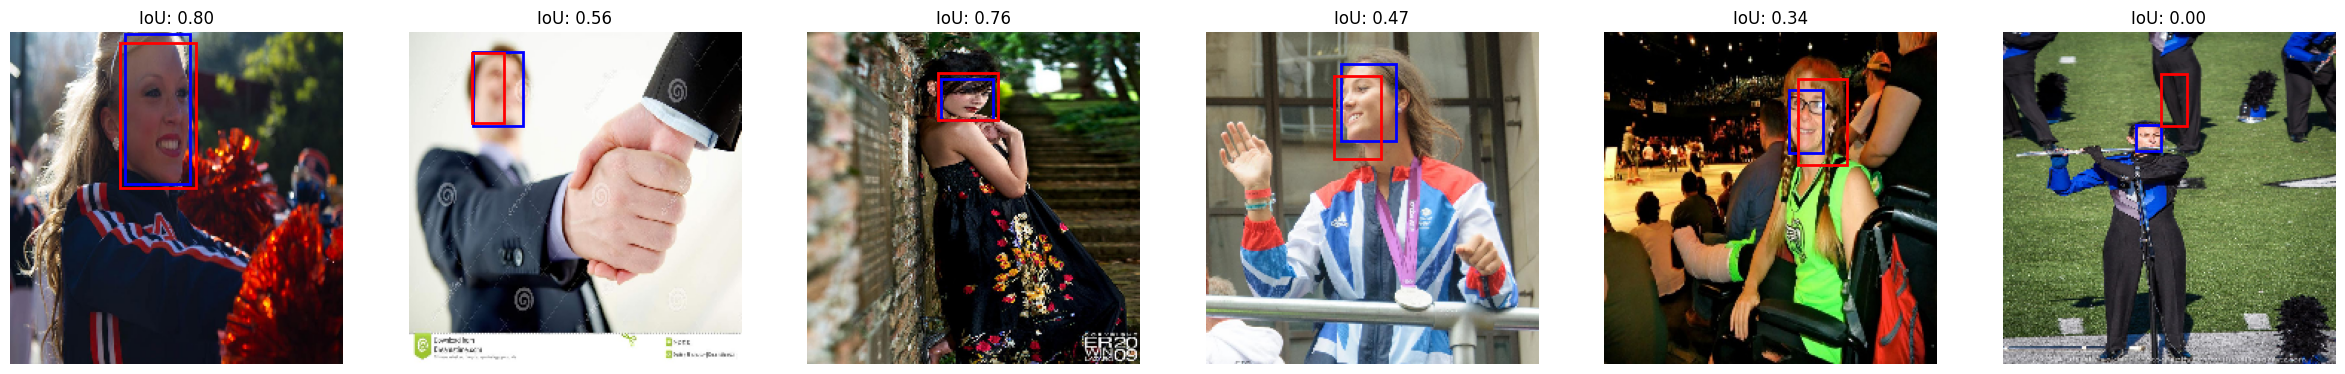

In [66]:
# Вызов визуализации (n — количество примеров)
visualize_detections(test_images[:100], test_bboxes[:100], predicted_bboxes[:100], ious, n=6)

In [47]:
predicted_bboxes[5:]

[array([[0.3635042 , 0.16827303, 0.77739334, 0.6458361 ]], dtype=float32),
 array([[0.36390147, 0.16910158, 0.77741206, 0.64592165]], dtype=float32),
 array([[0.3641318 , 0.1688559 , 0.77738166, 0.64523417]], dtype=float32),
 array([[0.3635014 , 0.16852391, 0.77779657, 0.64650965]], dtype=float32),
 array([[0.36342403, 0.16851   , 0.77727205, 0.6457387 ]], dtype=float32),
 array([[0.36343846, 0.16937393, 0.77741605, 0.6458473 ]], dtype=float32),
 array([[0.3633057 , 0.16851255, 0.77762663, 0.6465075 ]], dtype=float32),
 array([[0.36363748, 0.16853078, 0.7773975 , 0.6455549 ]], dtype=float32),
 array([[0.36352533, 0.16861713, 0.7776235 , 0.6461415 ]], dtype=float32),
 array([[0.3638164 , 0.1683525 , 0.7775551 , 0.64607435]], dtype=float32),
 array([[0.36351365, 0.16912767, 0.7766168 , 0.64483786]], dtype=float32),
 array([[0.36320907, 0.16878988, 0.7777889 , 0.6447393 ]], dtype=float32),
 array([[0.36364973, 0.16866845, 0.7774722 , 0.6459507 ]], dtype=float32),
 array([[0.36332604, 0.16

In [35]:
show_predictions_on_images(model, test_images, test_bboxes, test_labels, num=30, image_size=(224, 224))

In [36]:
def show_predictions_on_images_to_out(model, images, true_bboxes=None, labels=None, num=5, image_size=(224, 224)):
    """
    Отображает изображения с предсказанными bbox от модели и, опционально, реальными bbox и метками.
    Работает в Jupyter Notebook (через matplotlib).
    """
    h, w = image_size

    fig, axes = plt.subplots(1, num, figsize=(5 * num, 5))

    if num == 1:
        axes = [axes]

    for i in range(num):
        img = images[i]
        input_img = np.expand_dims(img, axis=0)

        # Предсказание модели (ожидается bbox [x1, y1, x2, y2])
        pred = model.predict(input_img, verbose=0)
        if isinstance(pred, list) and len(pred) == 2:
            pred_bbox = pred[0][0]
        else:
            pred_bbox = pred[0]

        pred_bbox = np.squeeze(pred_bbox)

        # Преобразуем нормализованные координаты в пиксели
        x1_pred = int(pred_bbox[0] * w)
        y1_pred = int(pred_bbox[1] * h)
        x2_pred = int(pred_bbox[2] * w)
        y2_pred = int(pred_bbox[3] * h)

        # Подготовка изображения
        img_disp = (img * 255).astype(np.uint8)

        ax = axes[i]
        ax.imshow(img_disp)
        ax.axis("off")
        ax.set_title(f"Image {i+1}")

        # Предсказанный bbox — красный
        rect_pred = patches.Rectangle((x1_pred, y1_pred),
                                      x2_pred - x1_pred,
                                      y2_pred - y1_pred,
                                      linewidth=2, edgecolor='red', facecolor='none', label='Predicted')
        ax.add_patch(rect_pred)

        # Истинный bbox — зелёный
        if true_bboxes is not None:
            x1_true = int(true_bboxes[i][0] * w)
            y1_true = int(true_bboxes[i][1] * h)
            x2_true = int(true_bboxes[i][2] * w)
            y2_true = int(true_bboxes[i][3] * h)

            rect_true = patches.Rectangle((x1_true, y1_true),
                                          x2_true - x1_true,
                                          y2_true - y1_true,
                                          linewidth=2, edgecolor='green', facecolor='none', label='Ground Truth')
            ax.add_patch(rect_true)

        # Метка класса (если есть)
        if labels is not None:
            ax.text(5, 20, f"Label: {labels[i]}", color='yellow', fontsize=12, bbox=dict(facecolor='black', alpha=0.5))

    plt.tight_layout()
    plt.show()


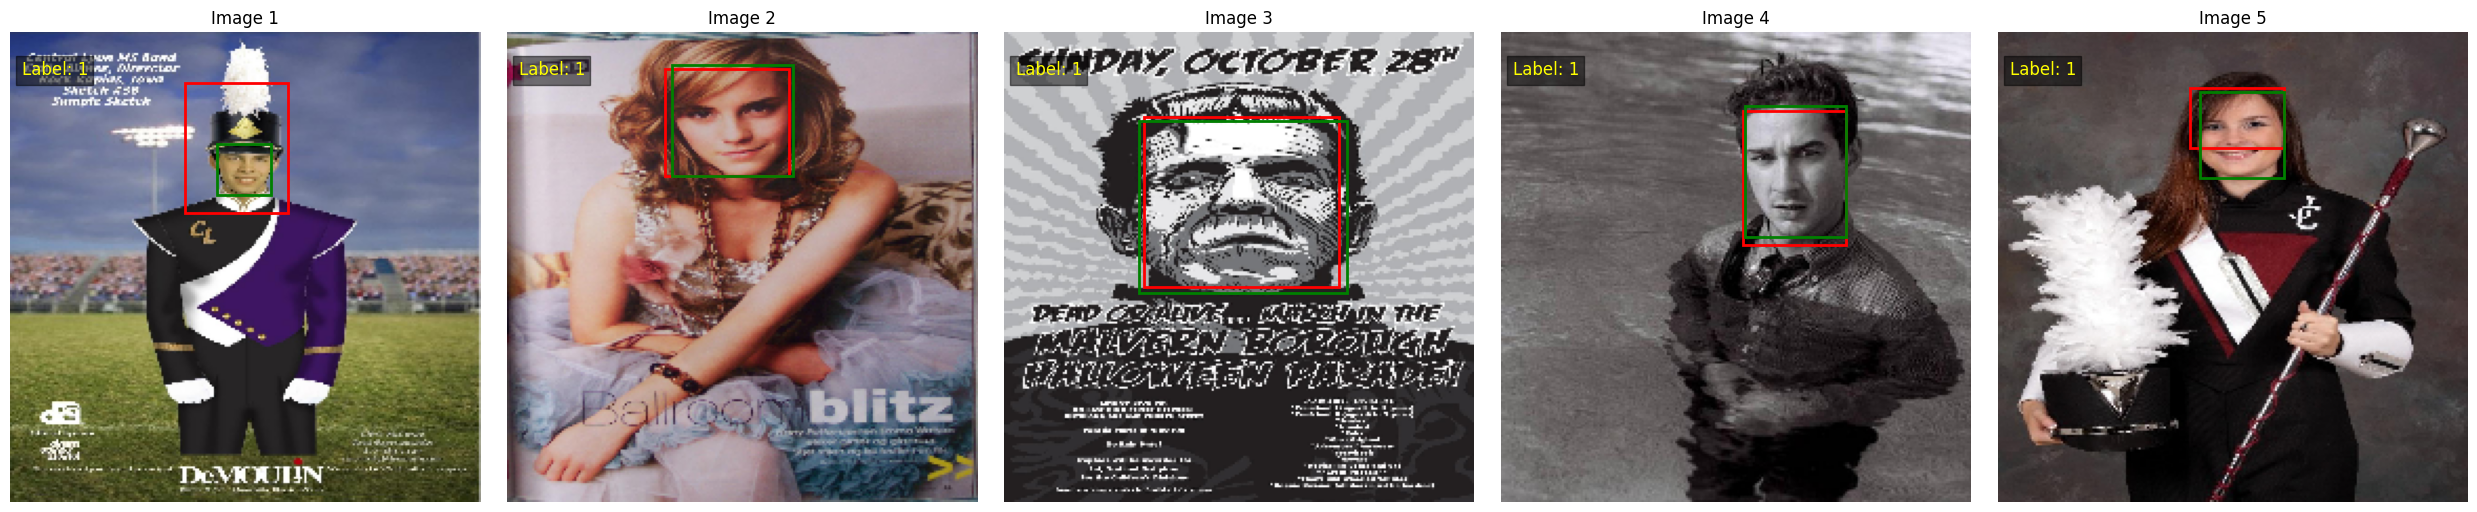

In [38]:
show_predictions_on_images_to_out(model, test_images, test_bboxes, test_labels, num=5, image_size=(224, 224))